### State Farm Distracted Driving: Classifying images based on driver safety

See Also: https://www.kaggle.com/praveenmaripeti/state-farm-distracted-driver-detection-with-keras for NN implemntation with tensorflow

Distracted driving causes a lot of accidents and is 100% preventable. Machine learning algorithms can gage driver safety using 2D dashboard camera images of drivers. The goal is to classify these images based on driver's behavior (cell phone, texting, etc). 

10 behaviors are classfied as follows:

In [2]:
classes = ['c0', 'c1', 'c2', 'c3', 'c4', 'c5', 'c6', 'c7', 'c8', 'c9']
#['c'+str(x) for x in range(10)]

class_def = {'c0': 'safe driving',
'c1': 'texting - right',
'c2': 'talking on the phone - right',
'c3': 'texting - left',
'c4': 'talking on the phone - left',
'c5': 'operating the radio',
'c6': 'drinking',
'c7': 'reaching behind',
'c8': 'hair and makeup',
'c9': 'talking to passenger'}

In [3]:
# Import Relevant Libaries
import os
from pathlib import Path
import numpy as np
import pandas as pd
from PIL import Image
import matplotlib.pyplot as plt
import random
#Create and load dataset
import h5py
import pickle # for PCA
#Train Test Split
from sklearn.model_selection import train_test_split
#SVM
from sklearn.pipeline import make_pipeline
from sklearn.decomposition import PCA
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV

#Learning Curve
from sklearn.model_selection import learning_curve

# Plotting
import matplotlib.pyplot as plt
import seaborn as sns

# metrics
from sklearn.metrics import confusion_matrix, classification_report 
from sklearn.metrics import accuracy_score as accuracy
from sklearn.metrics import recall_score as recall
from sklearn.metrics import precision_score as precision

In [26]:
# Some parameters for running the Notebook
# hdf5 filename 
downscale = 2
hdf5_train = f"StateFarm_Train_{downscale}X.h5" # scaled down by 5
hdf5_test = f"StateFarm_Test_{downscale}X.h5"
#"StateFarm_Train_2X.h5" # scaled down by 2
#"StateFarm_Train_5X.h5" # scaled down by 5 

#write image dataset? 
write_dataset = True
write_testset = False 

#run grid search for svm hyperparameters?
run_gridsearch = False

#PCA/SVM
runFullPCA = False
computeLearningCurve = False
computeLearningFull = True

PIK = "pca.dat"
PIK2 = "grid.dat"
PIK_learning = 'learning.dat'
PIK_learning_full = 'learning_X_y.dat'
#'learning_xtrain_ytrain.dat'
#learning_X_y_wtf.dat

### Make and/or  Load HDF5 dataset (training data) :
See: https://realpython.com/storing-images-in-python/
and the [github Page](https://github.com/realpython/materials/blob/storing-images/storing-images/storing_images.ipynb)


In [27]:
# directories and filepaths
data_dir = Path(os.path.join(os.getcwd(),'data'))
base_dir = Path(os.path.join(data_dir, "state-farm-distracted-driver-detection"))
img_folder = Path(os.path.join(base_dir, 'imgs'))
train_imgs = Path(os.path.join(img_folder, 'train'))
test_imgs = Path(os.path.join(img_folder, 'test'))
# load the image lists
driver_imgs_list = pd.read_csv(os.path.join(base_dir, 'driver_imgs_list.csv'))
sample_sub = pd.read_csv(os.path.join(base_dir, 'sample_submission.csv'))

In [28]:
# head of image list
driver_imgs_list.head()

,subject,classname,img
0,p002,c0,img_44733.jpg
1,p002,c0,img_72999.jpg
2,p002,c0,img_25094.jpg
3,p002,c0,img_69092.jpg
4,p002,c0,img_92629.jpg


In [29]:
def rescale_image(filepath, resize_scale=2, gray_scale=True):
  '''
  Loads image, converts to grayscale, downsamples by resize_scale and returns a 
  To keep color image, set gray_scale = True 
  To keep the original size of the image, set resize_scale= 1
  '''
  im = Image.open(filepath)
  if gray_scale:
    im = im.convert('L')
  if resize_scale > 1:
    resize_dims = tuple([int(x/resize_scale) for x in (im.size)])
    im = im.resize(resize_dims)
  # makes array 1 X Px X Py for easier concatenation  
  return np.array(im).reshape(1, np.array(im).shape[0], np.array(im).shape[1])

In [30]:
def writehdf5(file, image, label=None):
    # hdf5_dir directory that will contain hdf5_fname
    # hdf5_fname filename of the hd5 file being created ends with .h5
    # image is a nsamplesx n1pixel x n2pixel ndarray
    # label is ndarary containing the labels
    print(f"writing hdf5 file: {hdf5_fname} in {hdf5_dir}")
    #file = h5py.File(hdf5_dir / hdf5_fname, "a")
    #f.close()

    # Create a dataset in the file
    dataset = file.create_dataset(
        "image", np.shape(image), h5py.h5t.STD_U8BE, data=image
    )
    if label is not None:
        if isinstance(label[0], str): # list of strings
            meta_set = file.create_dataset("labels", data=np.array(label, dtype='S'))
        else:
            meta_set = file.create_dataset(
                "labels", np.shape(label), h5py.h5t.STD_U8BE, data=label
            )
    #file.close()

In [31]:
if write_dataset: #TRAINING DATA
    # NOTE: USING NP ARRAYS IS MUCH SLOWER THAN DOING A LIST
    # For training images data set (could probably parallelize this but...)
    classnames = driver_imgs_list['classname'].values
    labels = [int(x[1]) for x in classnames]
    filenames = driver_imgs_list['img'].values
    image_list = [] # make a list, then concatenate
    for i, file in enumerate(filenames):
        if i%1000  == 0:    
            print(f"adding {file} to list, i={i}") 
            
        path_to_file = Path(os.path.join(train_imgs, classnames[i], file))        
        image_list.append(rescale_image(path_to_file, resize_scale = downscale)) 
    # concatenate images into singe nd array  
    images = np.concatenate(image_list, axis= 0)
    #writehdf5(data_dir, hdf5_train, images, labels)

adding img_44733.jpg to list, i=0
adding img_98718.jpg to list, i=1000
adding img_29411.jpg to list, i=2000
adding img_69390.jpg to list, i=3000
adding img_39358.jpg to list, i=4000
adding img_93192.jpg to list, i=5000
adding img_29731.jpg to list, i=6000
adding img_23637.jpg to list, i=7000
adding img_5799.jpg to list, i=8000
adding img_36717.jpg to list, i=9000
adding img_30792.jpg to list, i=10000
adding img_55189.jpg to list, i=11000
adding img_99251.jpg to list, i=12000
adding img_47864.jpg to list, i=13000
adding img_63132.jpg to list, i=14000
adding img_52243.jpg to list, i=15000
adding img_25404.jpg to list, i=16000
adding img_99194.jpg to list, i=17000
adding img_43583.jpg to list, i=18000
adding img_17664.jpg to list, i=19000
adding img_54984.jpg to list, i=20000
adding img_59295.jpg to list, i=21000
adding img_63401.jpg to list, i=22000


In [11]:
if write_testset: # writes the TESTDATA to an hd5 file
    # get the filenames in the folder
    filenames = os.listdir(test_imgs)
    # nTestImages = len(filenames)
    image_list = []
    labels = []
    for i,file in enumerate(filenames):
        if i%5000 == 0:
            print(f'adding {file} to list i={i}')
        path_to_file = os.path.join(test_imgs, file)
        image_list.append(rescale_image(path_to_file, resize_scale=downscale))
        labels.append(file)
    # NOTE: for loop above would be a good place for parallelization (break up filenames list)
    # concatenate image_list (or lists if parallelize) itno a single list
    images = np.concatenate(image_list, axis= 0)

adding img_1.jpg to list i=0
adding img_13797.jpg to list i=5000
adding img_19562.jpg to list i=10000
adding img_25336.jpg to list i=15000
adding img_31120.jpg to list i=20000
adding img_36915.jpg to list i=25000
adding img_42694.jpg to list i=30000
adding img_48474.jpg to list i=35000
adding img_5424.jpg to list i=40000
adding img_59984.jpg to list i=45000
adding img_65737.jpg to list i=50000
adding img_71541.jpg to list i=55000
adding img_77326.jpg to list i=60000
adding img_83038.jpg to list i=65000
adding img_88826.jpg to list i=70000
adding img_94593.jpg to list i=75000


In [25]:
if write_testset:
    #file.close()
    file = h5py.File(data_dir / hdf5_test, "w")
    #writehdf5(file, images, labels)
    #file.close()
      # Create a dataset in the file
    dataset = file.create_dataset(
        "image", np.shape(images), h5py.h5t.STD_U8BE, data=images
    )
    meta_set = file.create_dataset("labels", data=np.array(labels, dtype='S'))
    file.close()
    

In [35]:
if write_dataset: 
    # each image is a row
    # data = images.reshape(images.shape[0], images.shape[1]*images.shape[2])
    
    print('Writing HDF5 file')
    # Create a new HDF5 file
    file = h5py.File(
        data_dir / hdf5_train, "w"
    )

    # Create a dataset in the file
    image_set = file.create_dataset(
        "images",
        np.shape(images),
        h5py.h5t.STD_U8BE,
        data=images,
    )
    classnames_set = file.create_dataset(
        "labels",
        np.shape(labels),
        h5py.h5t.STD_U8BE,
        data=labels,
    )    
    
    file.close()           

Writing HDF5 file


Load hdf5 training dataset:


In [8]:
images, labels = [], []

# Open the HDF5 file
file = h5py.File(data_dir / hdf5_train, "r+")
images = np.array(file["/images"]).astype("uint8")
labels = np.array(file["/labels"]).astype("uint8")
file.close()

In [9]:
image_size = images.shape
# Resize images as vectors
X = images.reshape(images.shape[0], images.shape[1]*images.shape[2])
y = labels
# Zero mean 
X = X - X.mean(axis=1).reshape(X.shape[0], 1)

Train, test split

In [10]:
xtrain, xcv, ytrain, ycv = train_test_split(X, y, test_size=0.3, random_state=42)

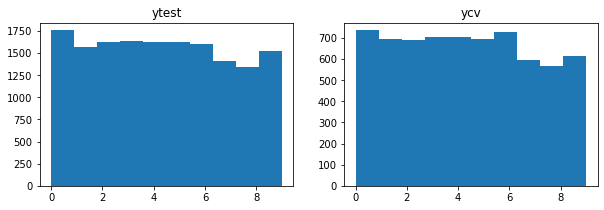

In [40]:
# Just make sure that the classes are represented equally (random distribution)
figure = plt.figure(figsize=(10,3))
ax = plt.subplot(121).hist(ytrain);
plt.title('ytest');
plt.subplot(122).hist(ycv);
plt.title('ycv');

### SVM: Preprocessing and model parameters

90% of the variance is explained by 160 components (unwhitened)
90% of the variance is explained by 160 components (whitened)
99% of the variance is explained by 2120 components


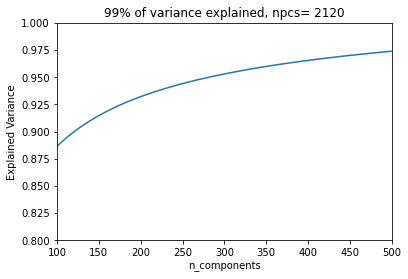

In [11]:
#Going to run pca, let's see how many components we may actually need
if runFullPCA:
    pca = PCA(n_components=0.90,random_state=42, svd_solver='full') # 0.90 of the variance
    pca99 = PCA(n_components=0.99,random_state=42, whiten=True, svd_solver='full') # 0.99 of the variance
    pca90 = PCA(n_components=0.90,random_state=42, whiten=True, svd_solver='full') # 0.90 of the variance
    pca99.fit(xtrain)
    pca90.fit(xtrain)
    # save output as pickle
    with open(PIK, "wb") as f:
        pickle.dump(pca, f)
        pickle.dump(pca90,f)
        pickle.dump(pca99,f)
        
with open(PIK, "rb") as f:
    pca = pickle.load(f)
    pca90 = pickle.load(f)
    pca99 = pickle.load(f)
f.close()
    
print(f"90% of the variance is explained by {pca.n_components_} components (unwhitened)")
print(f"90% of the variance is explained by {pca90.n_components_} components (whitened)")
print(f"99% of the variance is explained by {pca99.n_components_} components")
explained_variance = np.cumsum(pca99.explained_variance_)/(np.sum(pca99.explained_variance_)*.99)
plt.plot(np.arange(pca99.n_components_),explained_variance)
plt.xlim(100,500);
plt.ylim(0.8, 1);
plt.title(f'99% of variance explained, npcs= {pca99.n_components_}')
plt.xlabel('n_components');
plt.ylabel('Explained Variance');    


90% of the variance it is with 160 features! It's a slowly increasing curve which is also slowing down, hitting 95% at 450. At 200 hundred features, 92.5% percent of the variance is explained - doesn't seem worth an extra forty features.

Before doing this systematically, I was running with 150 components on images which were scaled down only 2x and the SVM performed pretty well on the cross validation. At 2x downscale, the size of the images did not allow for a full PCA. The number of pixels far outnumbered the number of training samples. The matrix was only full rank when images were scaled down to 5 times (in integers).  

Next it's time pick the parameters of the SVM via grid search

In [12]:
# initiate pipeline with 160 features
mypca = PCA(n_components=160, whiten=True, random_state= 42)
mysvm = SVC(kernel='rbf', class_weight='balanced')
model = make_pipeline(mypca, mysvm)

In [13]:
if run_gridsearch:
    param_grid = {'svc__C': [1, 5, 10, 50],
              'svc__gamma': [0.0001, 0.0005, 0.001, 0.005, .01, .1]}
    # Instantiate the grid search with the model and parameter grid
    grid = GridSearchCV(estimator=model, param_grid=param_grid)
    grid.fit(xtrain, ytrain)
    with open(PIK2, "wb") as f:
        pickle.dump(grid, f)

with open(PIK2, "rb") as f:
    grid = pickle.load(f)
f.close

print(grid.best_params_)
#print(grid.cv_results_)

means = grid.cv_results_['mean_test_score']
stds = grid.cv_results_['std_test_score']
for mean, std, param in zip(means, stds, grid.cv_results_['params']):
    print("%0.5f (+/-%0.05f) for %r"
          % (mean, std, param))
    # STILL WANNA PICK 0.99433 (+/-0.00037) for {'svc__C': 10, 'svc__gamma': 0.005} (SMALLER STD)

{'svc__C': 5, 'svc__gamma': 0.01}
0.88443 (+/-0.00532) for {'svc__C': 1, 'svc__gamma': 0.0001}
0.94476 (+/-0.00472) for {'svc__C': 1, 'svc__gamma': 0.0005}
0.96400 (+/-0.00293) for {'svc__C': 1, 'svc__gamma': 0.001}
0.99032 (+/-0.00033) for {'svc__C': 1, 'svc__gamma': 0.005}
0.99280 (+/-0.00033) for {'svc__C': 1, 'svc__gamma': 0.01}
0.75975 (+/-0.00769) for {'svc__C': 1, 'svc__gamma': 0.1}
0.93884 (+/-0.00519) for {'svc__C': 5, 'svc__gamma': 0.0001}
0.96987 (+/-0.00305) for {'svc__C': 5, 'svc__gamma': 0.0005}
0.98076 (+/-0.00239) for {'svc__C': 5, 'svc__gamma': 0.001}
0.99357 (+/-0.00031) for {'svc__C': 5, 'svc__gamma': 0.005}
0.99388 (+/-0.00031) for {'svc__C': 5, 'svc__gamma': 0.01}
0.78103 (+/-0.00678) for {'svc__C': 5, 'svc__gamma': 0.1}
0.95190 (+/-0.00410) for {'svc__C': 10, 'svc__gamma': 0.0001}
0.97477 (+/-0.00300) for {'svc__C': 10, 'svc__gamma': 0.0005}
0.98477 (+/-0.00211) for {'svc__C': 10, 'svc__gamma': 0.001}
0.99369 (+/-0.00042) for {'svc__C': 10, 'svc__gamma': 0.005}
0.

99.39% accuracy. This is similar to 99.49% accuracy using the 2x downscaled image with 150pcs. Maybe as good as this SVM may get? 

Let's fit the model and check the predictions of the cross validationset:

In [ ]:
# make model with chocen parameters
mypca = PCA(n_components=160, whiten=True, random_state= 42)
mysvm = SVC(C=5, gamma=0.01,kernel='rbf', class_weight='balanced')
model = make_pipeline(mypca, mysvm)
# fit the model to trianing data
history = model.fit(xtrain, ytrain)

In [19]:
# predict cross validation set
ypred_cv = model.predict(xcv)

In [23]:
print(classification_report(ycv, ypred_cv))

              precision    recall  f1-score   support

           0       0.99      1.00      0.99       735
           1       1.00      1.00      1.00       694
           2       1.00      0.99      1.00       691
           3       1.00      0.99      1.00       706
           4       0.99      1.00      0.99       706
           5       1.00      0.99      1.00       693
           6       1.00      1.00      1.00       729
           7       1.00      1.00      1.00       594
           8       0.98      0.99      0.99       568
           9       0.99      0.99      0.99       612

    accuracy                           0.99      6728
   macro avg       0.99      0.99      0.99      6728
weighted avg       0.99      0.99      0.99      6728



### Let's see how the svm/pca model learns
see also: [scikit learn example](https://scikit-learn.org/stable/auto_examples/model_selection/plot_learning_curve.html#sphx-glr-auto-examples-model-selection-plot-learning-curve-py)

In [24]:
mypca = PCA(n_components=160, whiten=True, random_state= 42)
mysvm = SVC(C=5, gamma=0.01, kernel='rbf', class_weight='balanced')
model = make_pipeline(mypca, mysvm)

if computeLearningCurve: 
    train_sizes, train_scores, test_scores, fit_times, _ = \
        learning_curve(model, xtrain, ytrain, n_jobs=-1,
                       train_sizes=[0.01, 0.05, 0.1, 0.325, 0.55 , 0.6, 0.775, 1.],
                       return_times=True, random_state=0)
    with open(PIK_learning, "wb") as f:
        pickle.dump(train_sizes, f)
        pickle.dump(train_scores, f)
        pickle.dump(test_scores, f)
        pickle.dump(fit_times,f)

with open(PIK_learning, "rb") as f:
    train_sizes = pickle.load(f)
    train_scores = pickle.load(f)
    test_scores = pickle.load(f)
    fit_times = pickle.load(f)
f.close()



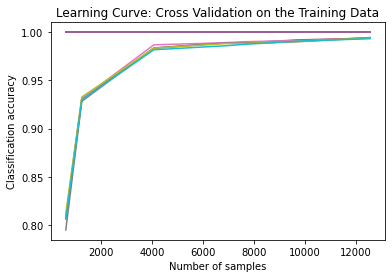

In [26]:
plt.plot(train_sizes,train_scores);
plt.plot(train_sizes,test_scores);
plt.xlabel('Number of samples');
plt.ylabel('Classification accuracy')
plt.title('Learning Curve: Cross Validation on the Training Data');

At 12,000 samples, the model may not have asympoted yet. Perhaps we can do better with more data.

Next, I'll be feeding in the whole training dataset X, instead of xtrain and have learning_curve do the cross validation as well. 

In [ ]:
if computeLearningFull:
    shuffled_indices = np.random.permutation(len(y))
    Xshuff = X[shuffled_indices, :]
    yshuff = y[shuffled_indices]
    train_sizes, train_scores, test_scores, fit_times, _ = \
            learning_curve(model, xtrain, ytrain, n_jobs=-1,
                           train_sizes=[0.01, 0.05, 0.1, 0.325, 0.55 , 0.6, 0.775, 1.],
                           return_times=True, random_state=0)
    with open(PIK_learning_full, "wb") as f:
        pickle.dump(train_sizes, f)
        pickle.dump(train_scores, f)
        pickle.dump(test_scores, f)
        pickle.dump(fit_times,f)

In [ ]:
f.close()